<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Training an Object Detection Model

In this notebook, we give an introduction to training an object detection model using [torchvision](https://pytorch.org/docs/stable/torchvision/index.html). Using a small dataset, we demonstrate how to train and evaluate a FasterRCNN object detection model. We also cover one of the most common ways to store data on a file system for this type of problem.

## Initialization

In [46]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# %load_ext blackcellmagic

Import all the functions we need.

In [21]:
import sys
sys.path.append("../../")

import os
import time
from pathlib import Path
from PIL import Image
from random import randrange
from typing import Tuple
import torch
from torchvision import transforms

from utils_cv.common.data import unzip_url, data_path
from utils_cv.detection.data import Urls
from utils_cv.detection.dataset import DetectionDataset
from utils_cv.detection.plot import display_bounding_boxes
from utils_cv.detection.model import DetectionLearner, get_bounding_boxes, get_transform
from utils_cv.common.gpu import which_processor

which_processor()

Torch is using GPU: Tesla V100-PCIE-16GB


This shows your machine's GPUs (if has any) and the computing device `torch/torchvision` is using. We suggest using an  [Azure DSVM](https://azure.microsoft.com/en-us/services/virtual-machines/data-science-virtual-machines/) Standard NC6 as a GPU compute resource.

Next, set some model runtime parameters. We use the `unzip_url` helper function to download and unzip the data used in this example notebook.

In [40]:
DATA_PATH     = unzip_url(Urls.fridge_objects_path, exist_ok=True)
EPOCHS        = 4
LEARNING_RATE = 0.005
# IM_SIZE       = 300
# BATCH_SIZE    = 16
# ARCHITECTURE  = models.resnet18

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

---

# Prepare Object Detection Dataset

In this notebook, we use a toy dataset called *Fridge Objects*, which consists of 134 images of 4 classes of beverage container `{can, carton, milk bottle, water bottle}` photos taken on different backgrounds. The helper function downloads and unzips data set to the `ComputerVision/data` directory.

Set that directory in the `path` variable for ease of use throughout the notebook.

In [4]:
path = Path(DATA_PATH)
os.listdir(path)

['.DS_Store', 'annotations', 'images']

You'll notice that we have two different folders inside:
- `/images`
- `/annotations`

This format for object detection is fairly common.

```
/data
+-- images
|   +-- image1.jpg
|   +-- image2.jpg
|   +-- ...
+-- annotations
|   +-- image1.xml
|   +-- image2.xml
|   +-- ...
+-- ...
```

The xml files inside the annotation folder contain information on where the objects are the xml's corresponding image file. In this example, our fridge object dataset is annotated in Pascal VOC format. This is one of the most common formats for labelling object detection datasets.

```xml
<!-- Example Pascal VOC annotation -->
<annotation>
    <folder>images</folder>
    <filename>1.jpg</filename>
    <path>../images/1.jpg</path>
    <source>
        <database>Unknown</database>
    </source>
    <size>
        <width>499</width>
        <height>666</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>

    <object>
        <name>carton</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <difficult>0</difficult>
        <bndbox>
            <xmin>100</xmin>
            <ymin>173</ymin>
            <xmax>233</xmax>
            <ymax>521</ymax>
        </bndbox>
    </object>
</annotation>
```

You'll notice that inside the annotation xml file, we can see which image the file references `<path>`, the number of `<objects>` in the image, that the image is of (`<name>`) and the bounding box of that object (`<bndbox>`).

# Load Images

To load the data, we need to create a Dataset object class that Torchvision knows how to use. In short, we'll need to create a class and implement the `__getitem__` method. More information here: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html#defining-the-dataset

To make it more convinient, we've created a `DetectionDataset` class that knows how to extract annotation information from the Pascal VOC format and meet the requirements of the Torchvision dataset object class. 

In [5]:
fridge_objects_dataset = DetectionDataset(DATA_PATH)

Lets visualize some of the images to make sure the annotation looks correct.

In [6]:
fridge_objects_dataset.show_batch(rows=2)

# Finetune a Pretrained Model

For the DetectionLearner, we use FasterRCNN as the default model, and Stochastic Gradient Descent as our default optimizer. 

Our FasterRCNN model is pretrained on COCO, a large-scale object detection, segmentation, and captioning dataset that contains over 200K labeled images with over 80 label cateogories.

When we create initialize DetectionLearner, we perform the following steps:
1. split our dataset into train/test sets, and create the dataloaders for each
1. set the model to the torchvision's FasterRCNN
1. setup the optimizer, SGD in our case
1. set a learning rate scheduler to torch.optim.lr_scheduler.StepLR

In [7]:
detector = DetectionLearner(fridge_objects_dataset, LEARNING_RATE)

Inspect our Datasets/DataLoaders to make sure it looks right.

In [28]:
print(f"""\
Training dataset: {len(detector.train_ds)} | Training DataLoader: {detector.train_dl}
Testing dataset: {len(detector.test_ds)} | Testing DataLoader: {detector.test_dl} \
""")

Training dataset: 78 | Training DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7f1da041c940>
Testing dataset: 50 | Testing DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7f1da041cac8> 


Fine-tune the model using our training data loader (`train_dl`) and evaluate our results using our testing data loader (`test_dl`).

In [73]:
detector.fit(EPOCHS, print_freq=30)

Epoch: [0]  [ 0/39]  eta: 0:00:16  lr: 0.000136  loss: 0.0104 (0.0104)  loss_classifier: 0.0069 (0.0069)  loss_box_reg: 0.0013 (0.0013)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0021 (0.0021)  time: 0.4177  data: 0.1652  max mem: 4347
Epoch: [0]  [10/39]  eta: 0:00:06  lr: 0.001451  loss: 0.0104 (0.0132)  loss_classifier: 0.0068 (0.0083)  loss_box_reg: 0.0018 (0.0021)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0023 (0.0027)  time: 0.2130  data: 0.0191  max mem: 4347
Epoch: [0]  [20/39]  eta: 0:00:03  lr: 0.002765  loss: 0.0109 (0.0129)  loss_classifier: 0.0068 (0.0075)  loss_box_reg: 0.0018 (0.0020)  loss_objectness: 0.0001 (0.0009)  loss_rpn_box_reg: 0.0023 (0.0025)  time: 0.1930  data: 0.0050  max mem: 4347
Epoch: [0]  [30/39]  eta: 0:00:01  lr: 0.004080  loss: 0.0112 (0.0130)  loss_classifier: 0.0076 (0.0078)  loss_box_reg: 0.0016 (0.0021)  loss_objectness: 0.0001 (0.0006)  loss_rpn_box_reg: 0.0024 (0.0025)  time: 0.1935  data: 0.0055  max mem: 4347
Epoch: [

Visualize the loss over time.

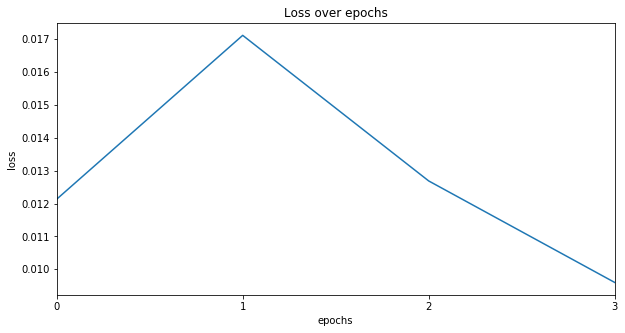

In [76]:
detector.plot_losses()

In [63]:
e = detector.evaluate()

creating index...
index created!
Test:  [ 0/25]  eta: 0:00:06  model_time: 0.0975 (0.0975)  evaluator_time: 0.0022 (0.0022)  time: 0.2685  data: 0.1652  max mem: 4347
Test:  [24/25]  eta: 0:00:00  model_time: 0.0725 (0.0738)  evaluator_time: 0.0022 (0.0024)  time: 0.0815  data: 0.0049  max mem: 4347
Test: Total time: 0:00:02 (0.0903 s / it)
Averaged stats: model_time: 0.0725 (0.0738)  evaluator_time: 0.0022 (0.0024)
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.685
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.750
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.750
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.685
 Average Recall     (AR) @[ Io

In [89]:
for iou_type, coco_eval in e.coco_eval.items():
    print(coco_eval.cocoGt)

# Inference

In [22]:
# select image
im_path = test_ds.dataset.root/'images'/test_ds.dataset.ims[randrange(len(test_ds))]
im = Image.open(im_path)

# Define PyTorch Transform
transform = transforms.Compose([transforms.ToTensor()])

# Apply the transform to the image
im = transform(im).cuda()

In [23]:
# put the model in evaluation mode
model = detector.get_model().eval()

with torch.no_grad():
    start = time.time()
    pred = model([im])
    print(f"Time spend: {time.time() - start}")

Time spend: 0.14491987228393555


In [24]:
pred_labels, pred_boxes = get_bounding_boxes(pred)
display_bounding_boxes(pred_boxes, [fridge_objects_dataset.categories[l] for l in pred_labels], im_path)

In [25]:
fridge_objects_dataset.categories

['can', 'carton', 'milk_bottle', '__background__', 'water_bottle']